Notebook for exploring the relation between topological data analysis (TDA) features and behavioral data in the females from the training group. 

TDA data is constructed using the HCP_features.py file, which also used TDA code from Fernando. 

Behavioral data is constructed using the Make_cog_file_HCP Jupyer Notebook. 
Behavioral data is splitted into train and test group using Split_HCP_data_males Jupyter Notebook, or Split_HCP_data_females for females


# Import and order data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm
import numpy as np

In [2]:
tda = pd.read_csv("/Users/minneschepers/Desktop/HCP/TDA_data/TDA_features_HCP_pvalued_train_females.csv")
bd = pd.read_csv("/Users/minneschepers/Desktop/HCP/Behavioral_Data/Females_train.csv")

In [3]:
bd.shape

(203, 41)

In [4]:
tda.shape

(203, 65)

In [5]:
tda.head()

,Subject,Euler_sum,S_entropy_dim0,S_entropy_dim1,bc_AUC_dim0,bc_AUC_dim1,curv_ent_DMN_0.005,curv_ent_DMN_0.01,curv_ent_DMN_0.02,curv_ent_FPN_0.005,...,p3cliques_FPN_ent_p1high,p3cliques_FPN_ent_p1low,p3cliques_FPN_sum_p1high,p3cliques_FPN_sum_p1low,pl_AUC_dim0,pl_AUC_dim1,top_vec_dim0,top_vec_dim1,total_cliques_sum,triangles_sum
0,HCA8074170,12600.0,80.803384,57.263668,22167.676768,1362.626263,4.406719,4.406719,4.406719,3.806662,...,0.0,0.0,0.0,0.0,36.034933,11.962296,0.499880,0.278842,12600.0,0.0
1,HCA9156783,12600.0,80.192207,61.408008,23155.555556,2253.535354,4.406719,4.406719,4.406719,3.806662,...,0.0,0.0,0.0,0.0,36.041318,13.601687,0.499925,0.305965,12600.0,0.0
2,HCA9880405,12600.0,77.637977,53.342736,21423.232323,2964.646465,4.406719,4.406719,4.406719,3.806662,...,0.0,0.0,0.0,0.0,36.051909,24.935341,0.500000,0.415770,12600.0,0.0
3,HCA6785193,12600.0,83.838445,72.782301,21563.636364,2144.444444,4.406719,4.406719,4.406719,3.806662,...,0.0,0.0,0.0,0.0,35.982806,16.321411,0.499511,0.326708,12600.0,0.0
4,HCA9956008,12600.0,85.917892,52.802578,18929.292929,1972.727273,4.406719,4.406719,4.406719,3.806662,...,0.0,0.0,0.0,0.0,36.031849,17.433317,0.499858,0.345787,12600.0,0.0


In [6]:
tda['Subject']

0      HCA8074170
1      HCA9156783
2      HCA9880405
3      HCA6785193
4      HCA9956008
          ...    
198    HCA9202057
199    HCA6818889
200    HCA8476190
201    HCA6427066
202    HCA6470673
Name: Subject, Length: 203, dtype: object

In [6]:
# Only include subjects from bd which are also in tda
same = bd['subject'].isin(tda['Subject'])
print(same.value_counts())
bd.drop(bd[~same].index, inplace = True)
print(bd.shape)

True    203
Name: subject, dtype: int64
(203, 41)


In [7]:
# Only include subjects from tda which are also in bd
same = tda['Subject'].isin(bd['subject'])
print(same.value_counts())
tda.drop(tda[~same].index, inplace = True)
print(tda.shape)

True    203
Name: Subject, dtype: int64
(203, 65)


In [8]:
# Sort bd by subject and reset index before concatenating
bd.sort_values(by=['subject'], inplace=True)
bd.reset_index(drop=True, inplace=True)
print(bd['subject'])

0      HCA6018857
1      HCA6030645
2      HCA6051047
3      HCA6062456
4      HCA6086470
          ...    
198    HCA9914193
199    HCA9938814
200    HCA9953406
201    HCA9956008
202    HCA9992517
Name: subject, Length: 203, dtype: object


In [9]:
# Sort tda by subject and reset index before concatenating
tda.sort_values(by=['Subject'], inplace=True)
tda.reset_index(drop=True, inplace=True)
print(tda['Subject'])

0      HCA6018857
1      HCA6030645
2      HCA6051047
3      HCA6062456
4      HCA6086470
          ...    
198    HCA9914193
199    HCA9938814
200    HCA9953406
201    HCA9956008
202    HCA9992517
Name: Subject, Length: 203, dtype: object


In [10]:
# Concatenate bd and tda into df
print(bd.shape)
print(tda.shape)
df = pd.concat([bd, tda], axis=1)
print(df.shape)

(203, 41)
(203, 65)
(203, 106)


In [11]:
# Create EF (executive functioning column) as mean of flanker and dccs
df['EF_age'] = df[['flanker_age', 'dccs_age']].mean(axis=1)
df['EF_unadjusted'] = df[['flanker_unadjusted', 'dccs_unadjusted']].mean(axis=1)

# Order bd columns in lists
age_adjusted = [i for i in bd.columns if '_age' in i]
age_adjusted.append('EF_age')
age_adjusted.append('age_years')
unadjusted = [i for i in bd.columns if '_unadjusted' in i]
unadjusted.append('EF_unadjusted')
natper = [i for i in bd.columns if '_np' in i]
subject_information = ['subject',  'sex', 'age_months']
WM = ['lswmt_unadjusted', 'lswmt_age']
EF = ['dccs_unadjusted', 'dccs_age',
       'flanker_unadjusted', 'flanker_age',
      'EF_unadjusted', 'EF_age']

In [12]:
# Order tda columns in lists
tda_features = tda.columns[1:]

DMN_curvatures = [i for i in tda_features if 'DMN' in i if 'curv' in i]
FPN_curvatures = [i for i in tda_features if 'FPN' in i if 'curv' in i]
all_curvatures = [i for i in tda_features if 'all' in i if 'curv' in i]
p3_cliques = [i for i in tda_features if 'p3cliques' in i]
p4_cliques = [i for i in tda_features if 'p4cliques' in i]
global_features = [i for i in tda_features if i not in DMN_curvatures if i not in FPN_curvatures if i not in all_curvatures if i not in p3_cliques if i not in p4_cliques]

WM_age = ['lswmt_age']
EF_age = ['dccs_age', 'flanker_age', 'EF_age']
all_kur = [i for i in tda_features if 'kur' in i]
all_skew = [i for i in tda_features if 'skew' in i]
all_std = [i for i in tda_features if 'std' in i]
all_ent = [i for i in tda_features if 'curv_ent' in i]

---
# Create dataframe without nan values


In [13]:
to_include = age_adjusted + unadjusted

In [14]:
# Only include age_adjusted, and then add subject column
df_no_nan = df[to_include]
df_no_nan['subject'] = list(df['subject'])
df_no_nan['EF_unadjusted'] = list(df['EF_unadjusted'])
print(df_no_nan.shape)

(203, 26)


<ipython-input-14-3ffb2cdb13d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan['subject'] = list(df['subject'])
<ipython-input-14-3ffb2cdb13d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan['EF_unadjusted'] = list(df['EF_unadjusted'])


In [15]:
# Show number of non_nan_values per column
df_no_nan.count()

fluidcog_age                175
crystalcog_age              174
earlychildcog_age           175
totalcog_age                175
dccs_age                    176
flanker_age                 176
lswmt_age                   176
orrt_age                    176
pcps_age                    176
picseq_age                  176
pvt_age                     176
EF_age                      176
age_years                   203
fluidcog_unadjusted         182
crystalcog_unadjusted       181
earlychildcog_unadjusted    182
totalcog_unadjusted         182
dccs_unadjusted             183
flanker_unadjusted          183
lswmt_unadjusted            183
orrt_unadjusted             183
pcps_unadjusted             183
picseq_unadjusted           183
pvt_unadjusted              183
EF_unadjusted               183
subject                     203
dtype: int64

In [16]:
# Drop all nan values
df_no_nan = df_no_nan.dropna()

In [17]:
# Add tda data to df_no_nan
same = tda['Subject'].isin(df_no_nan['subject'])
tda.drop(tda[~same].index, inplace = True)

In [18]:
# Sort tda data and reset index
tda.sort_values(by=['Subject'], inplace=True)
tda.reset_index(drop=True, inplace=True)
# Sort df and reset index
df_no_nan.sort_values(by=['subject'], inplace=True)
df_no_nan.reset_index(drop=True, inplace=True)

# Merge dataframes
print(df_no_nan.shape)
print(tda.shape)
df_no_nan = pd.concat([df_no_nan, tda], axis=1)
print(df_no_nan.shape)

(173, 26)
(173, 65)
(173, 91)


In [19]:
df_no_nan.to_csv('/Users/minneschepers/Desktop/HCP/Data/Females_filtered_exp.csv', index=False)

# Data exploration

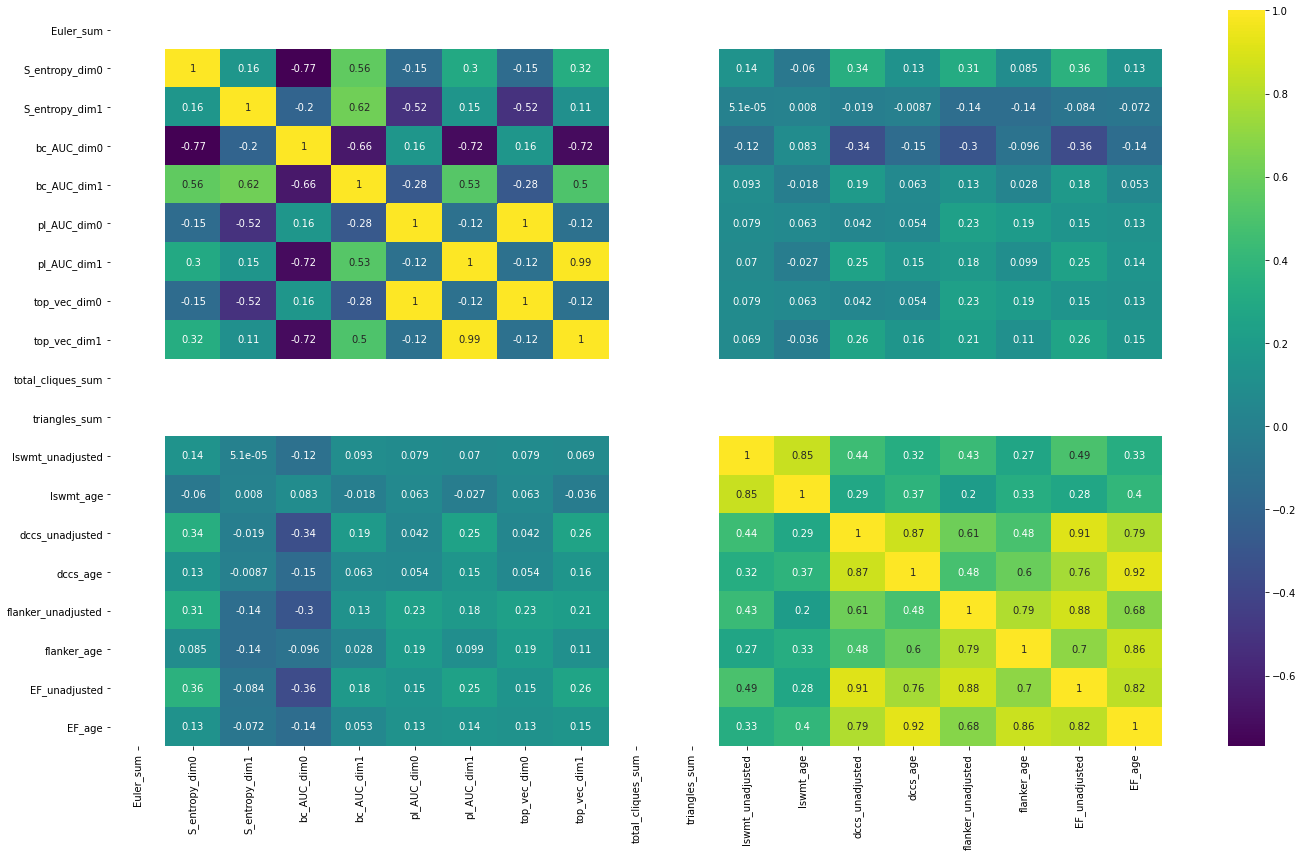

In [20]:
to_compare = global_features + WM + EF
fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(df_no_nan[to_compare].corr(), annot=True, cmap='viridis')
plt.tight_layout()

In [21]:
# to_compare = DMN_curvatures + WM + EF
# fig, ax = plt.subplots(figsize=(25,15))
# sns.heatmap(df_no_nan[to_compare].corr(), annot=True, cmap='viridis')
# plt.tight_layout()
# plt.savefig('/Users/minneschepers/Downloads/DMN_curvatures.png')

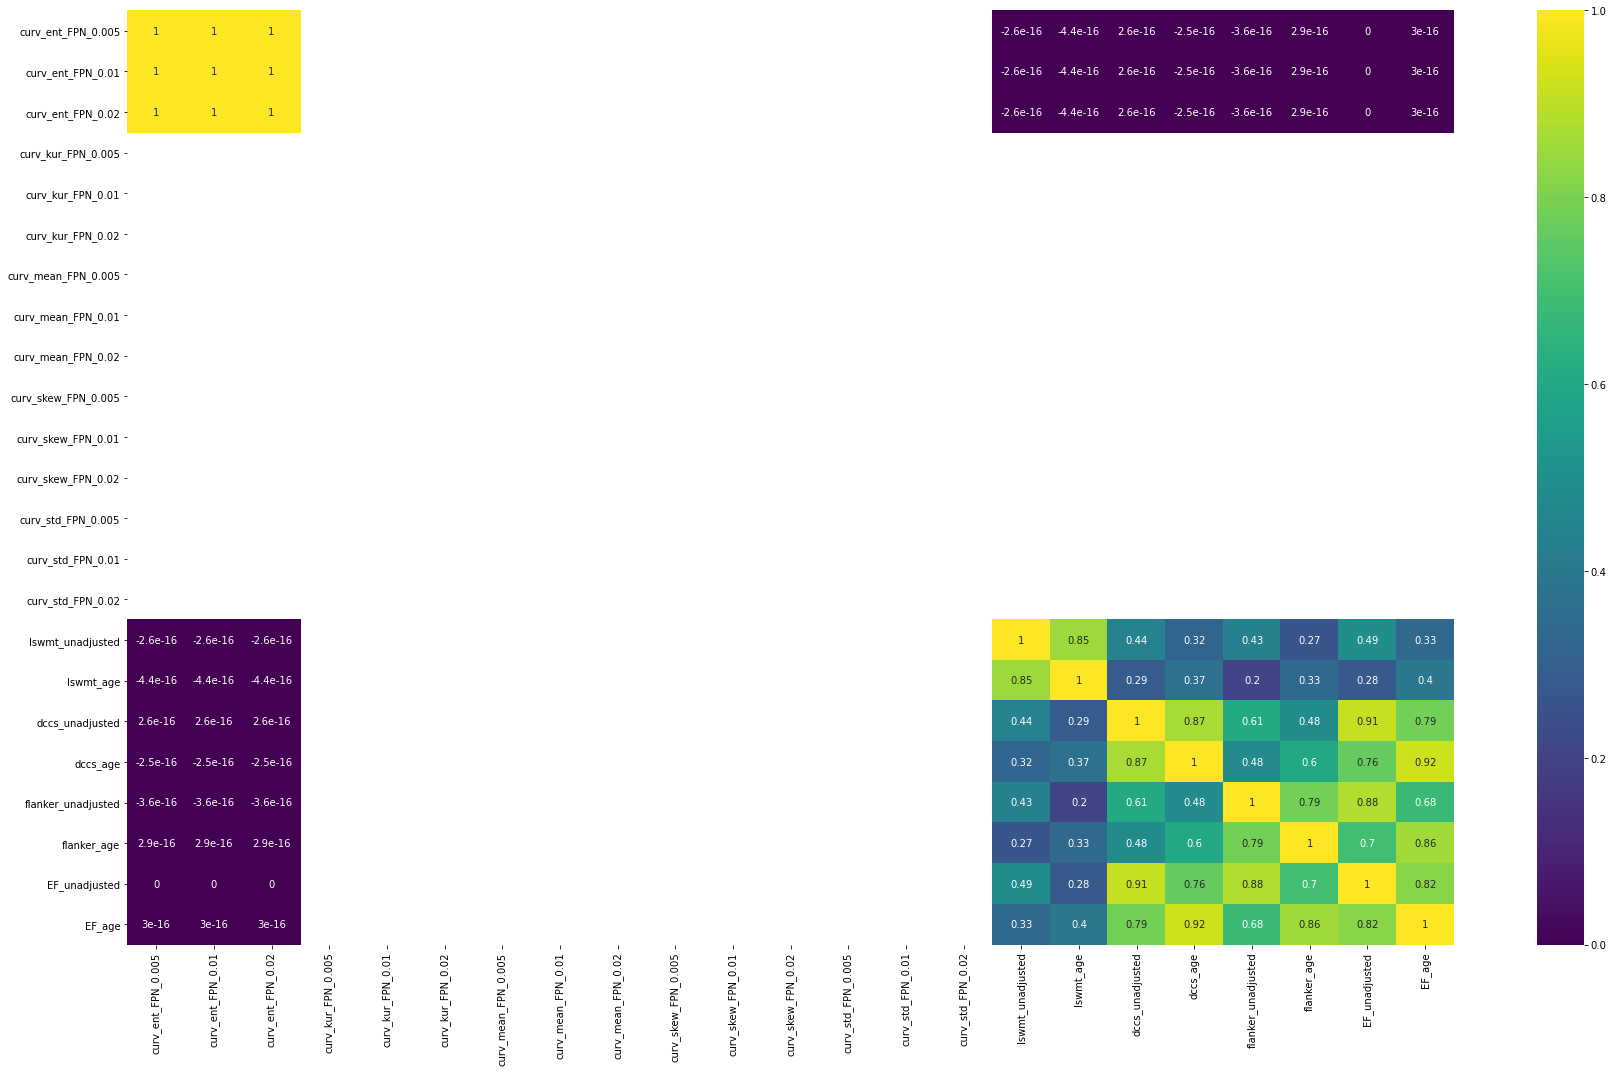

In [22]:
to_compare = FPN_curvatures + WM + EF
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(df_no_nan[to_compare].corr(), annot=True, cmap='viridis')
plt.tight_layout()
plt.savefig('/Users/minneschepers/Downloads/FPN_curvatures.png')

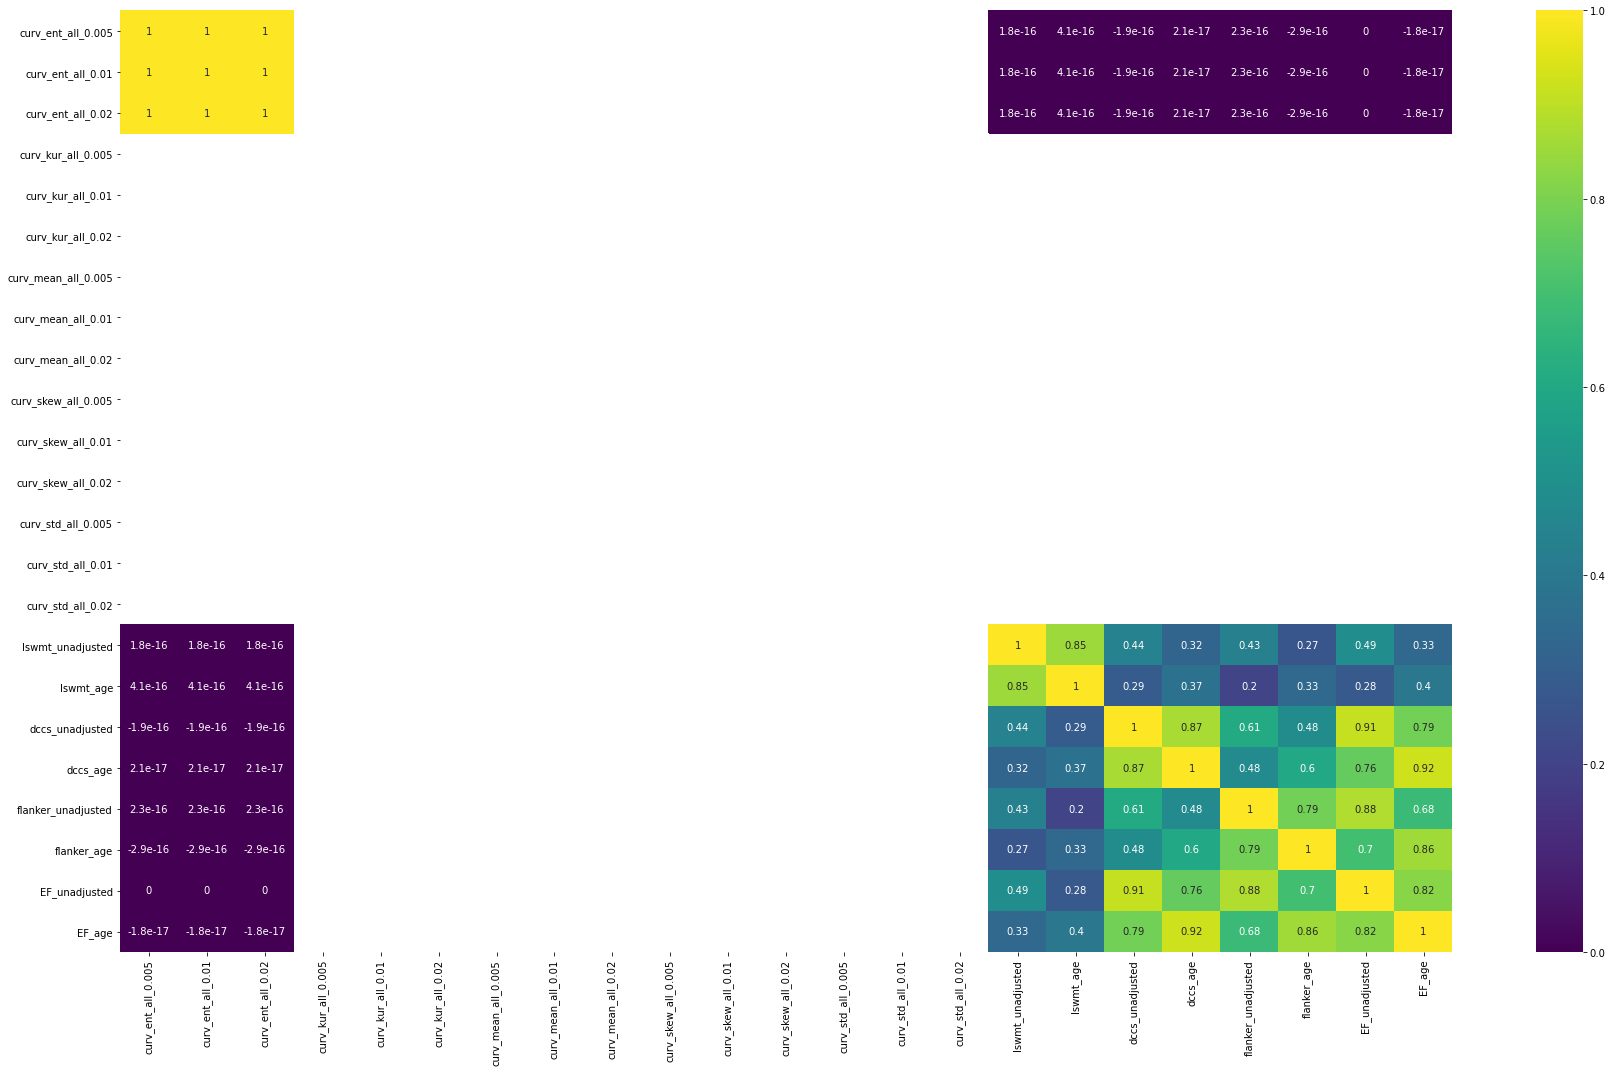

In [23]:
to_compare = all_curvatures + WM + EF
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(df_no_nan[to_compare].corr(), annot=True, cmap='viridis')
plt.tight_layout()
plt.savefig('/Users/minneschepers/Downloads/all_curvatures.png')

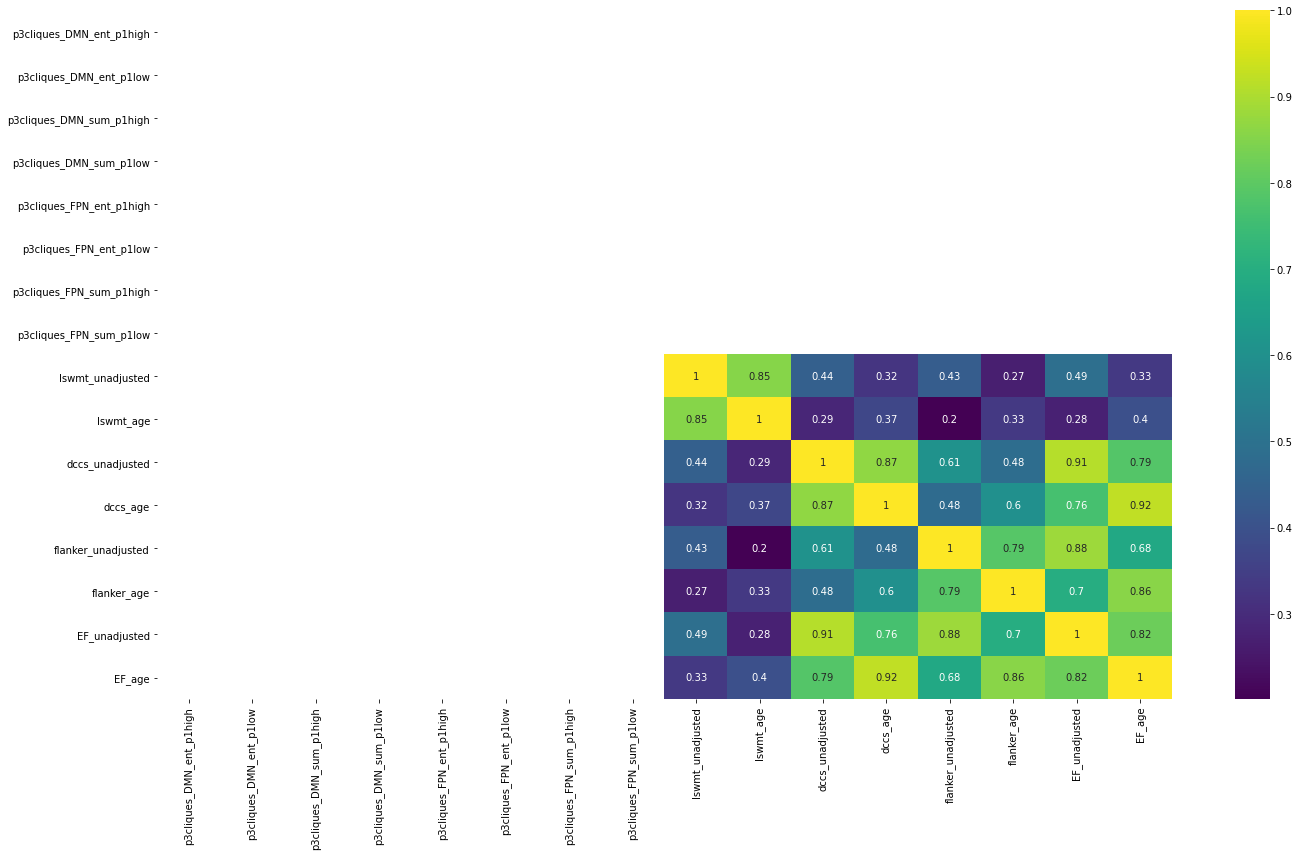

In [24]:
to_compare = p3_cliques + WM + EF
fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(df_no_nan[to_compare].corr(), annot=True, cmap='viridis')
plt.tight_layout()

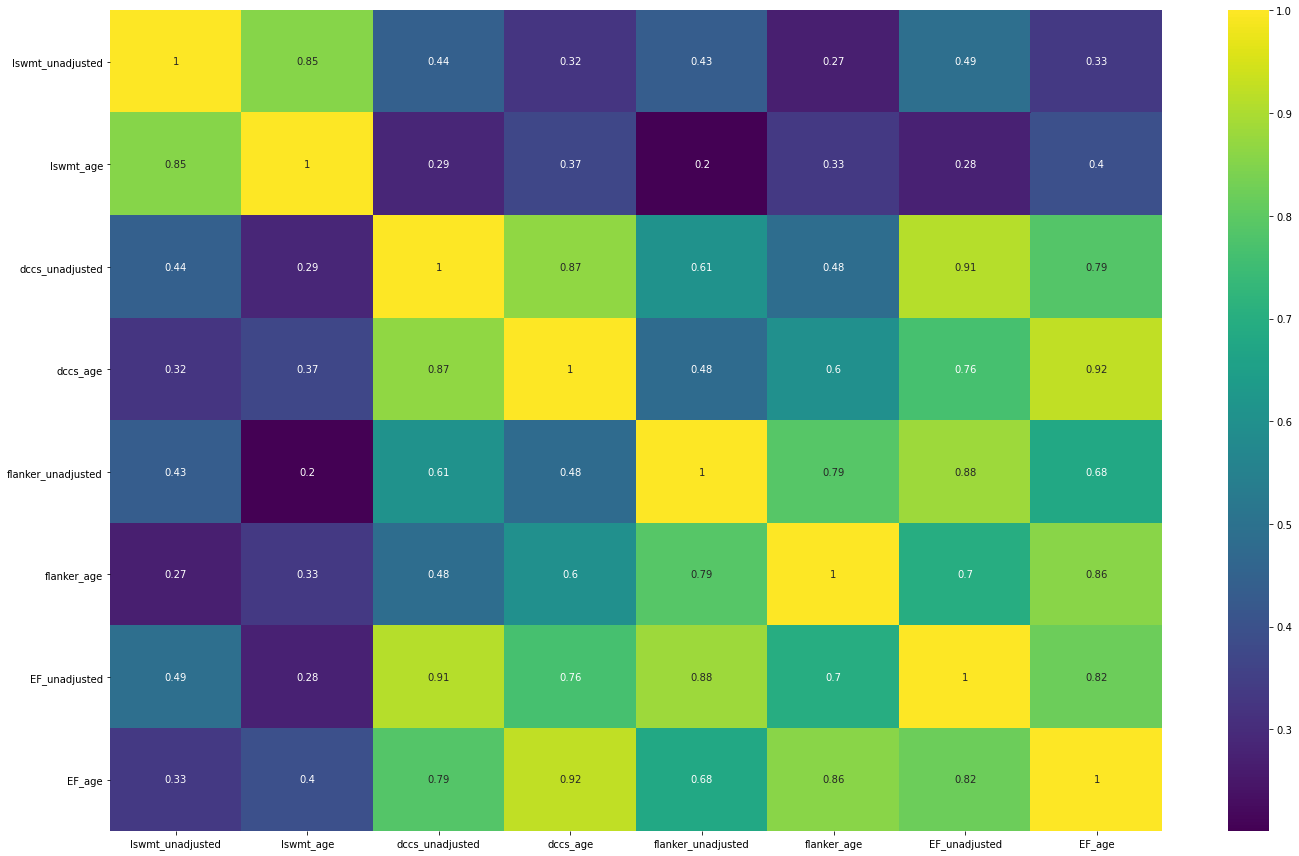

In [25]:
to_compare = p4_cliques + WM + EF
fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(df_no_nan[to_compare].corr(), annot=True, cmap='viridis')
plt.tight_layout()

### Define functions for data exploration:

In [26]:
def regplot(X_column, y_column, df):
    
    X = df[X_column]
    y = df[y_column]
    
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    p_value = round(est2.pvalues[1], 5)
    R2 = round(est2.rsquared, 5)

    sns.regplot(x=X, y=y)
    plt.figtext(0.72, 0.78, f' R2: {R2} \n p: {p_value}', fontsize=10)
    plt.xlabel(X_column)
    plt.ylabel(y_column)
    plt.show()

In [27]:
def z_scored_df(df, X_column, cut_off, print_zscores):
    
    z_scored = np.abs(stats.zscore(df[X_column]))
    if print_zscores == 1:
        print(z_scored)
    filtered = (z_scored < cut_off)#.all(axis=1)
    df_new = df[filtered]
    print(f'Shape old df: {df.shape}')
    print(f'Shape new df: {df_new.shape}')
    
    return df_new

In [28]:
def z_scored_regplot(x, y, dataframe, cut_off, print_zscores):
    
    X_column = x
    y = y
    df = dataframe
    
    regplot(X_column, y, z_scored_df(df, X_column, cut_off=cut_off, print_zscores=print_zscores))

In [29]:
def get_best_predictors(x, y, dataframe, n, zscore):
        
    # This function gets the n best predictors for a target and produces regression plots
    
    print(f'\n---------------- y = {y} ----------------\n')
    df = dataframe
    columns = []
    
    [columns.append(i) for i in x]
    columns.append(y)

    # Create correlation matrix
    corr = df[columns].corr()
    # Only include column with corr values with y-column, and exclude row with y (autocorrelation)
    # Absolutize to also get large negative correlation values
    corr = np.abs(corr.iloc[:-1,-1:])
    # Get n largest corr values
    corr = corr.nlargest(n, corr.columns)
    print(corr)
    # Save predictors to list
    best_predictors = corr.index.to_list()
    # Make for each predictor regression plot
    if zscore == 0:
        [regplot(predictor, y, df) for predictor in best_predictors]
    else:
        [z_scored_regplot(predictor, y, df, cut_off=zscore, print_zscores=0) for predictor in best_predictors]
    print(best_predictors)
    
# get_best_predictors(global_features, 'fluidcog_age', df_no_nan, n=3, zscore=0)

### Differences between outcomes adjusted by age and unadjusted by age

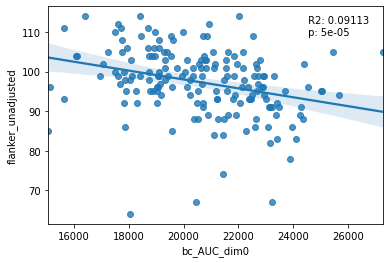

In [30]:
regplot('bc_AUC_dim0', 'flanker_unadjusted', df=df_no_nan)

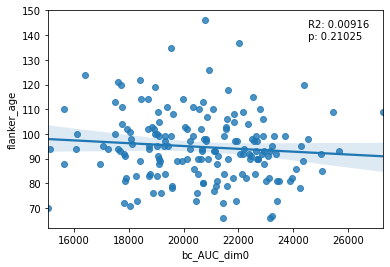

In [31]:
regplot('bc_AUC_dim0', 'flanker_age', df=df_no_nan)

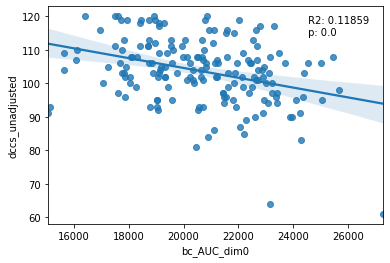

In [32]:
regplot('bc_AUC_dim0', 'dccs_unadjusted', df=df_no_nan)

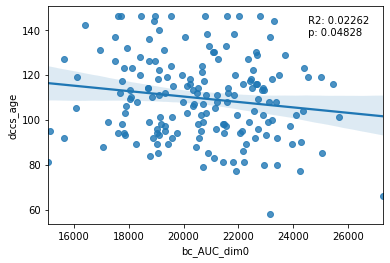

In [33]:
regplot('bc_AUC_dim0', 'dccs_age', df=df_no_nan)

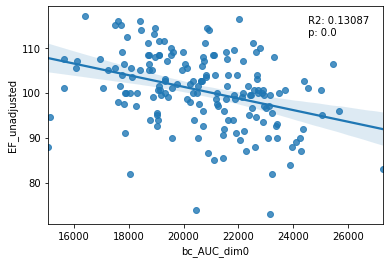

In [34]:
regplot('bc_AUC_dim0', 'EF_unadjusted', df=df_no_nan)

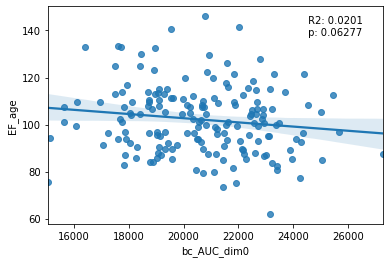

In [35]:
regplot('bc_AUC_dim0', 'EF_age', df=df_no_nan)

----
### Data exploration per outcome:

Age


---------------- y = age_years ----------------

                age_years
S_entropy_dim0   0.449947
bc_AUC_dim0      0.441402
top_vec_dim1     0.269396
pl_AUC_dim1      0.250997
bc_AUC_dim1      0.233148
Shape old df: (173, 91)
Shape new df: (172, 91)


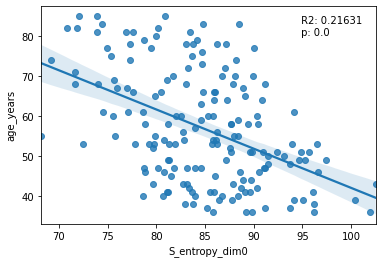

Shape old df: (173, 91)
Shape new df: (173, 91)


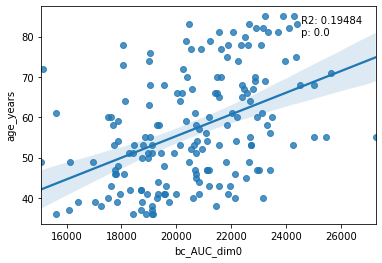

Shape old df: (173, 91)
Shape new df: (173, 91)


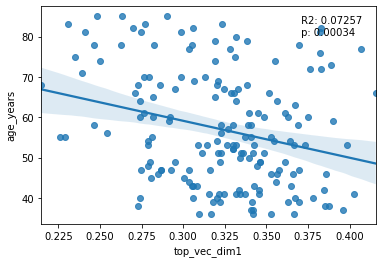

Shape old df: (173, 91)
Shape new df: (173, 91)


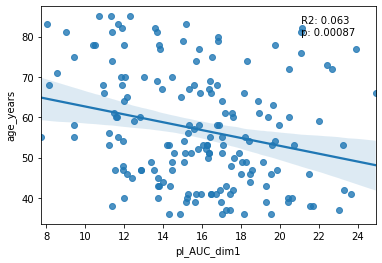

Shape old df: (173, 91)
Shape new df: (171, 91)


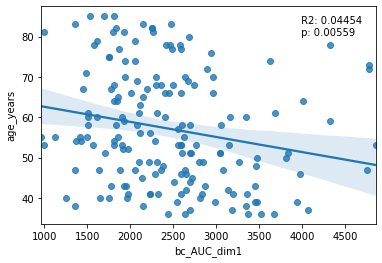

['S_entropy_dim0', 'bc_AUC_dim0', 'top_vec_dim1', 'pl_AUC_dim1', 'bc_AUC_dim1']


In [36]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'age_years', df_no_nan, n=5, zscore=3)

fluidcog_age
- Flanker, Dimensional Change Card Sort, Picture Sequence Memory, List Sorting, Pattern Comparison test

Results:



---------------- y = fluidcog_age ----------------

                fluidcog_age
bc_AUC_dim0         0.198802
top_vec_dim1        0.173587
pl_AUC_dim1         0.168875
S_entropy_dim0      0.161214
bc_AUC_dim1         0.088524
Shape old df: (173, 91)
Shape new df: (173, 91)


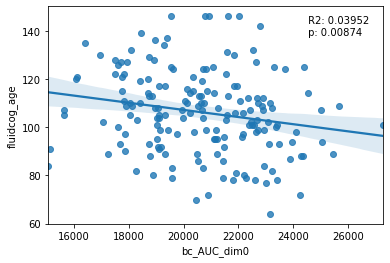

Shape old df: (173, 91)
Shape new df: (173, 91)


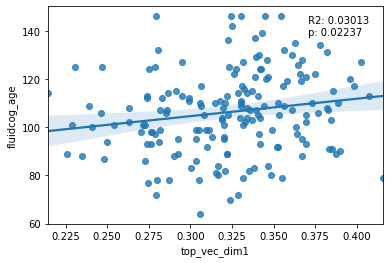

Shape old df: (173, 91)
Shape new df: (173, 91)


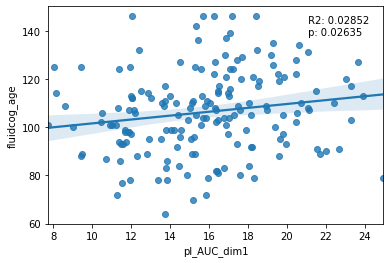

Shape old df: (173, 91)
Shape new df: (172, 91)


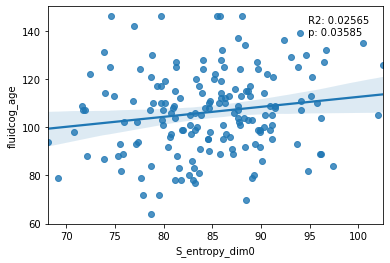

Shape old df: (173, 91)
Shape new df: (171, 91)


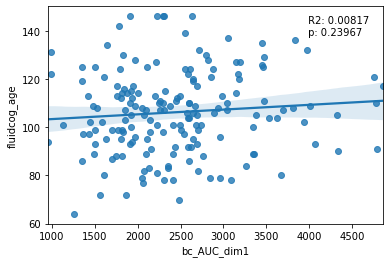

['bc_AUC_dim0', 'top_vec_dim1', 'pl_AUC_dim1', 'S_entropy_dim0', 'bc_AUC_dim1']


In [37]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'fluidcog_age', df_no_nan, n=5, zscore=3)

---

crystalcog_age
- Oral Reading Recognition Test and Picture Vocabulary Test

Results:



---------------- y = crystalcog_age ----------------

                crystalcog_age
top_vec_dim1          0.154265
pl_AUC_dim1           0.129304
bc_AUC_dim0           0.126420
S_entropy_dim1        0.115028
S_entropy_dim0        0.102869
Shape old df: (173, 91)
Shape new df: (173, 91)


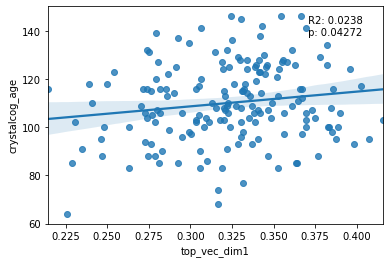

Shape old df: (173, 91)
Shape new df: (173, 91)


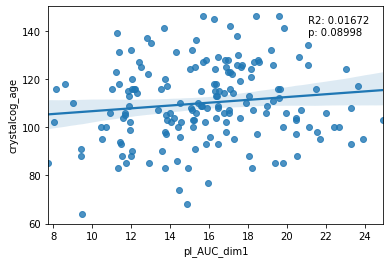

Shape old df: (173, 91)
Shape new df: (173, 91)


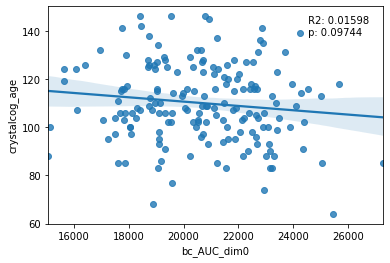

Shape old df: (173, 91)
Shape new df: (170, 91)


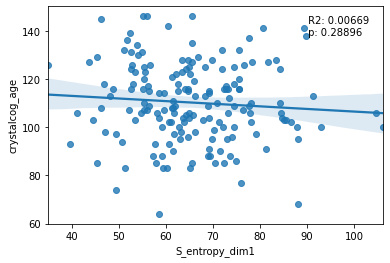

Shape old df: (173, 91)
Shape new df: (172, 91)


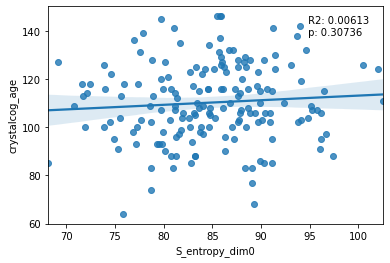

['top_vec_dim1', 'pl_AUC_dim1', 'bc_AUC_dim0', 'S_entropy_dim1', 'S_entropy_dim0']


In [38]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'crystalcog_age', df_no_nan, n=5, zscore=3)

---

earlychildcog_age


Results:



---------------- y = earlychildcog_age ----------------

                earlychildcog_age
bc_AUC_dim0              0.183925
top_vec_dim1             0.180245
pl_AUC_dim1              0.164958
S_entropy_dim0           0.151618
S_entropy_dim1           0.108441
Shape old df: (173, 91)
Shape new df: (173, 91)


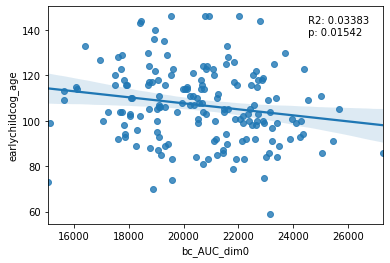

Shape old df: (173, 91)
Shape new df: (173, 91)


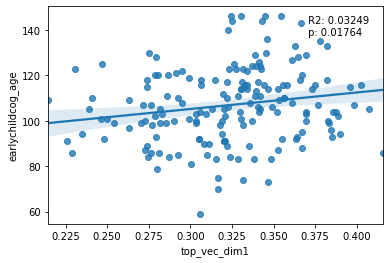

Shape old df: (173, 91)
Shape new df: (173, 91)


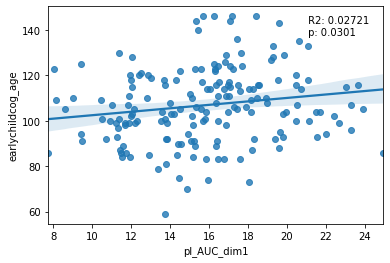

Shape old df: (173, 91)
Shape new df: (172, 91)


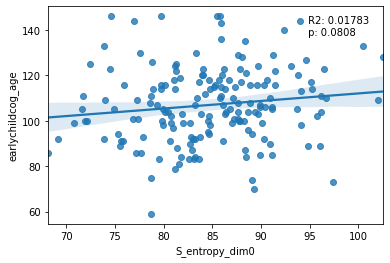

Shape old df: (173, 91)
Shape new df: (170, 91)


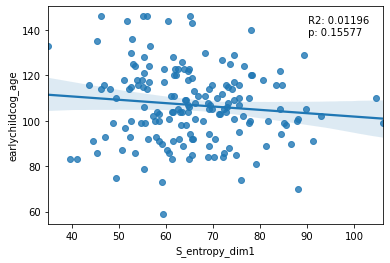

['bc_AUC_dim0', 'top_vec_dim1', 'pl_AUC_dim1', 'S_entropy_dim0', 'S_entropy_dim1']


In [39]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'earlychildcog_age', df_no_nan, n=5, zscore=3)

---

totalcog_age

Results:



---------------- y = totalcog_age ----------------

                totalcog_age
top_vec_dim1        0.189982
bc_AUC_dim0         0.189738
pl_AUC_dim1         0.173478
S_entropy_dim0      0.155982
S_entropy_dim1      0.102864
Shape old df: (173, 91)
Shape new df: (173, 91)


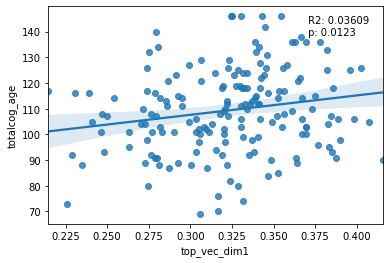

Shape old df: (173, 91)
Shape new df: (173, 91)


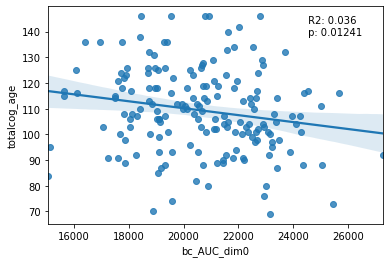

Shape old df: (173, 91)
Shape new df: (173, 91)


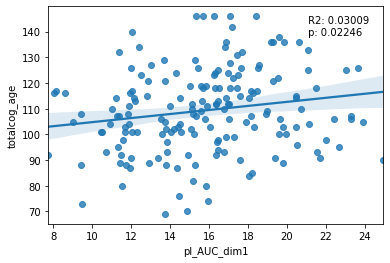

Shape old df: (173, 91)
Shape new df: (172, 91)


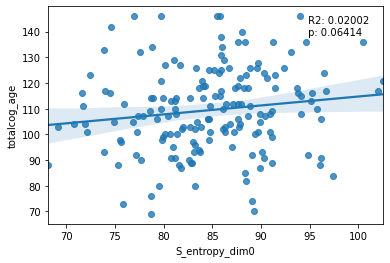

Shape old df: (173, 91)
Shape new df: (170, 91)


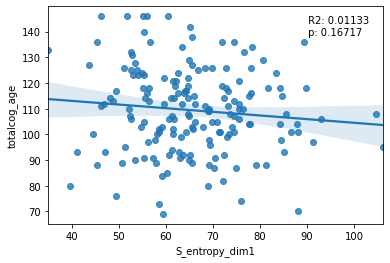

['top_vec_dim1', 'bc_AUC_dim0', 'pl_AUC_dim1', 'S_entropy_dim0', 'S_entropy_dim1']


In [40]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'totalcog_age', df_no_nan, n=5, zscore=3)

----

dccs_age:
- Dimensional change card sort
- Measures Executive functioning / cognitive flexibility

Results:



---------------- y = dccs_age ----------------

                dccs_age
top_vec_dim1    0.155820
pl_AUC_dim1     0.152192
bc_AUC_dim0     0.150386
S_entropy_dim0  0.133121
bc_AUC_dim1     0.062610
Shape old df: (173, 91)
Shape new df: (173, 91)


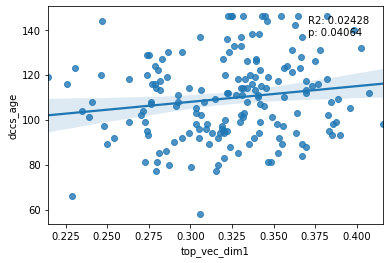

Shape old df: (173, 91)
Shape new df: (173, 91)


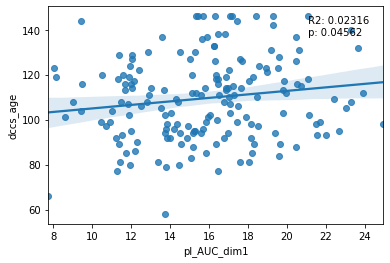

Shape old df: (173, 91)
Shape new df: (173, 91)


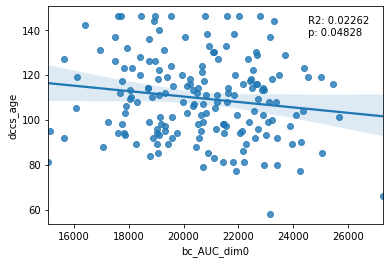

Shape old df: (173, 91)
Shape new df: (172, 91)


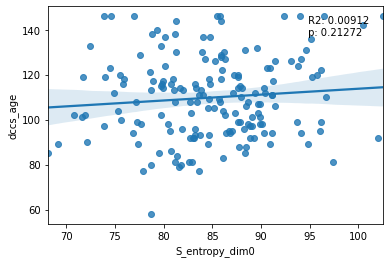

Shape old df: (173, 91)
Shape new df: (171, 91)


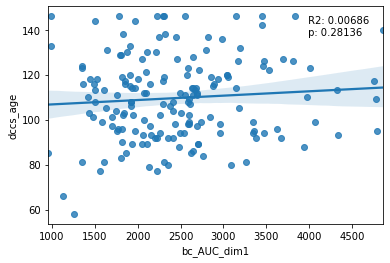

['top_vec_dim1', 'pl_AUC_dim1', 'bc_AUC_dim0', 'S_entropy_dim0', 'bc_AUC_dim1']


In [41]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'dccs_age', df_no_nan, n=5, zscore=3)

----

flanker_age:
- Flanker task
- Measures Executive Function/Inhibition

Results:



---------------- y = flanker_age ----------------

                flanker_age
pl_AUC_dim0        0.194282
top_vec_dim0       0.194278
S_entropy_dim1     0.139527
top_vec_dim1       0.111728
Shape old df: (173, 91)
Shape new df: (170, 91)


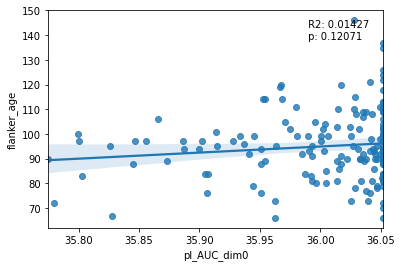

Shape old df: (173, 91)
Shape new df: (170, 91)


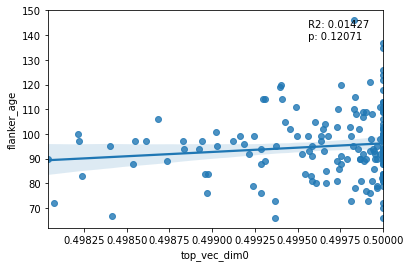

Shape old df: (173, 91)
Shape new df: (170, 91)


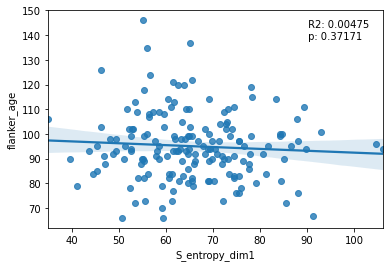

Shape old df: (173, 91)
Shape new df: (173, 91)


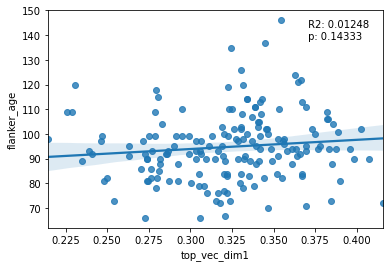

['pl_AUC_dim0', 'top_vec_dim0', 'S_entropy_dim1', 'top_vec_dim1']


In [42]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'flanker_age', df_no_nan, n=4, zscore=3)

---

EF_age

- The mean of the age corrected scores for flanker and dccs (dimensional change card sort)

Results:



---------------- y = EF_age ----------------

                EF_age
top_vec_dim1  0.152873
pl_AUC_dim1   0.144417
bc_AUC_dim0   0.141789
top_vec_dim0  0.127041
pl_AUC_dim0   0.127037
Shape old df: (173, 91)
Shape new df: (173, 91)


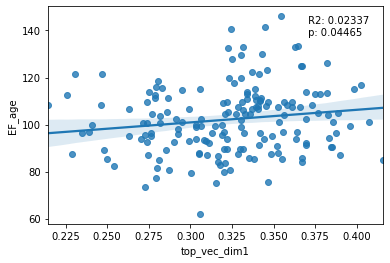

Shape old df: (173, 91)
Shape new df: (173, 91)


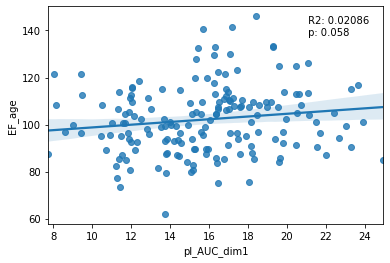

Shape old df: (173, 91)
Shape new df: (173, 91)


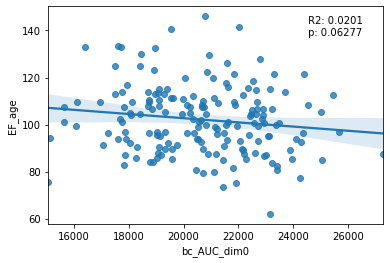

Shape old df: (173, 91)
Shape new df: (170, 91)


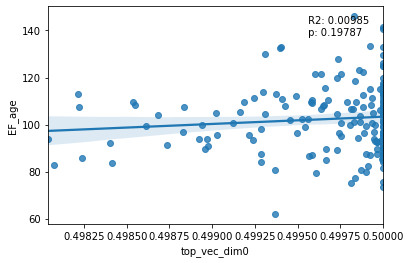

Shape old df: (173, 91)
Shape new df: (170, 91)


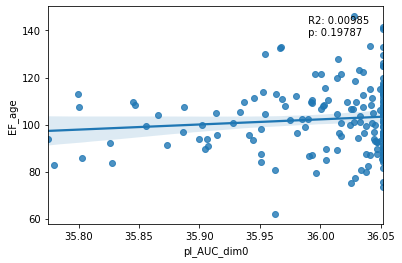

['top_vec_dim1', 'pl_AUC_dim1', 'bc_AUC_dim0', 'top_vec_dim0', 'pl_AUC_dim0']


In [43]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'EF_age', df_no_nan, n=5, zscore=3)

----

lswmt_age
- List sorting task
- Measures working Memory

Results:



---------------- y = lswmt_age ----------------

              lswmt_age
bc_AUC_dim0    0.082984
top_vec_dim0   0.063331
Shape old df: (173, 91)
Shape new df: (173, 91)


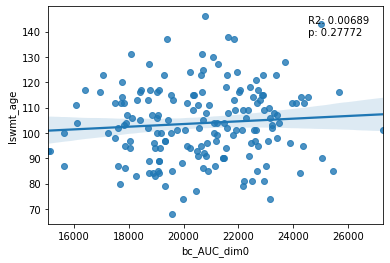

Shape old df: (173, 91)
Shape new df: (170, 91)


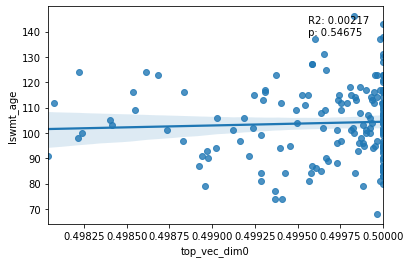

['bc_AUC_dim0', 'top_vec_dim0']


In [44]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'lswmt_age', df_no_nan, n=2, zscore=3)

----

orrt_age
- Oral Reading Recognition
- Measures language and reading decoding

Results:



---------------- y = orrt_age ----------------

                orrt_age
top_vec_dim1    0.165277
pl_AUC_dim1     0.138319
bc_AUC_dim0     0.125607
S_entropy_dim1  0.099599
Shape old df: (173, 91)
Shape new df: (173, 91)


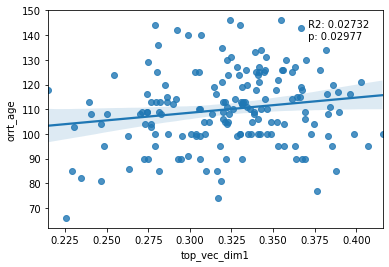

Shape old df: (173, 91)
Shape new df: (173, 91)


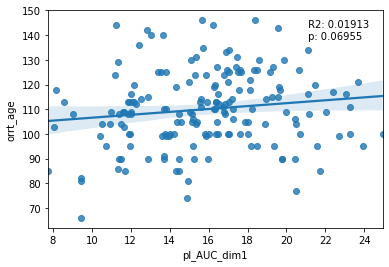

Shape old df: (173, 91)
Shape new df: (173, 91)


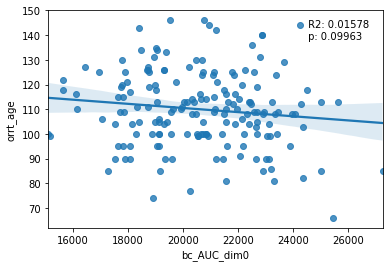

Shape old df: (173, 91)
Shape new df: (170, 91)


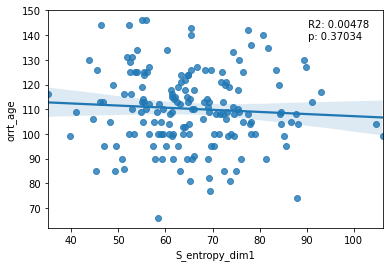

['top_vec_dim1', 'pl_AUC_dim1', 'bc_AUC_dim0', 'S_entropy_dim1']


In [45]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'orrt_age', df_no_nan, n=4, zscore=3)

PCPS_age:
- Pattern completion Processing Speed
- Measures processing speed

Results:



---------------- y = pcps_age ----------------

                pcps_age
bc_AUC_dim0     0.278006
S_entropy_dim0  0.223629
top_vec_dim1    0.201893
Shape old df: (173, 91)
Shape new df: (173, 91)


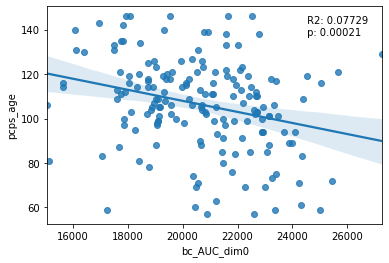

Shape old df: (173, 91)
Shape new df: (172, 91)


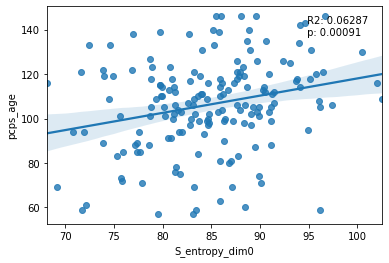

Shape old df: (173, 91)
Shape new df: (173, 91)


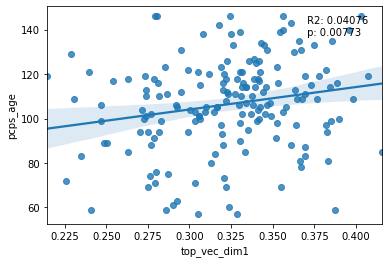

['bc_AUC_dim0', 'S_entropy_dim0', 'top_vec_dim1']


In [46]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'pcps_age', df_no_nan, n=3, zscore=3)

----

Picseq_age
- Picture sequence memory
- Measures episodic memory

Results:



---------------- y = picseq_age ----------------

              picseq_age
bc_AUC_dim0     0.181681
top_vec_dim1    0.135982
Shape old df: (173, 91)
Shape new df: (173, 91)


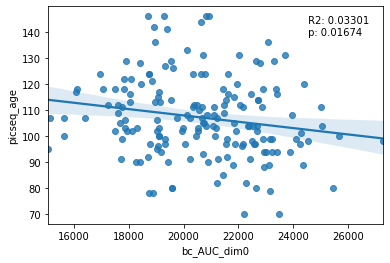

Shape old df: (173, 91)
Shape new df: (173, 91)


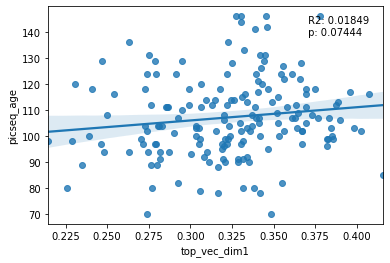

['bc_AUC_dim0', 'top_vec_dim1']


In [47]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'picseq_age', df_no_nan, n=2, zscore=3)

----

pvt_age:
- Picture Vocabulary task
- measures language/vocabulary comprehension

Results:



---------------- y = pvt_age ----------------

                 pvt_age
top_vec_dim1    0.125867
S_entropy_dim1  0.112028
bc_AUC_dim0     0.110673
pl_AUC_dim1     0.106564
S_entropy_dim0  0.094728
top_vec_dim0    0.030610
pl_AUC_dim0     0.030608
bc_AUC_dim1     0.000741
Shape old df: (173, 91)
Shape new df: (173, 91)


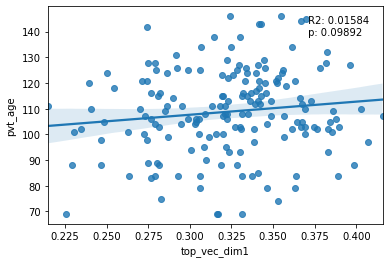

Shape old df: (173, 91)
Shape new df: (170, 91)


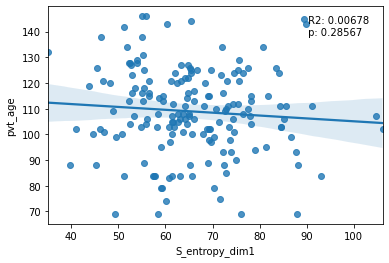

Shape old df: (173, 91)
Shape new df: (173, 91)


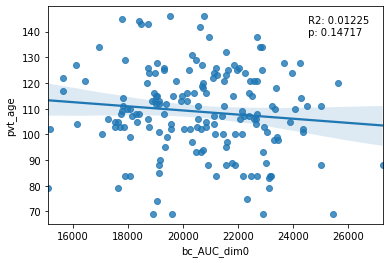

Shape old df: (173, 91)
Shape new df: (173, 91)


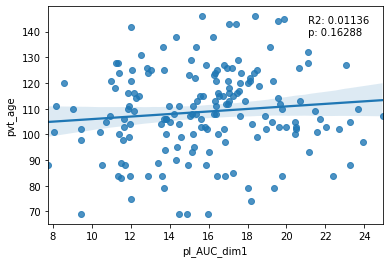

Shape old df: (173, 91)
Shape new df: (172, 91)


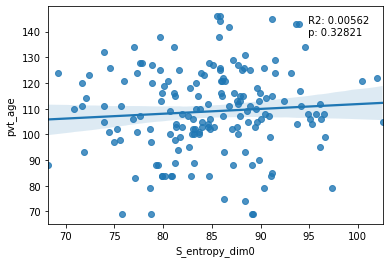

Shape old df: (173, 91)
Shape new df: (170, 91)


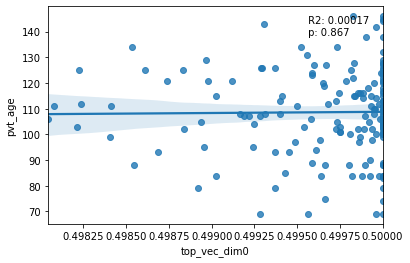

Shape old df: (173, 91)
Shape new df: (170, 91)


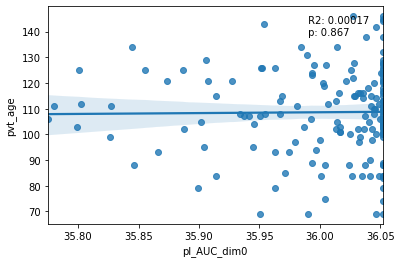

Shape old df: (173, 91)
Shape new df: (171, 91)


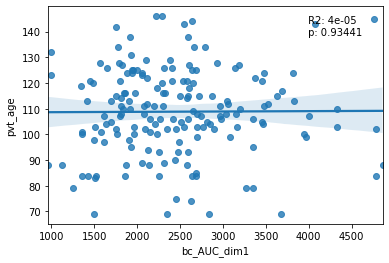

['top_vec_dim1', 'S_entropy_dim1', 'bc_AUC_dim0', 'pl_AUC_dim1', 'S_entropy_dim0', 'top_vec_dim0', 'pl_AUC_dim0', 'bc_AUC_dim1']


In [48]:
selected_features = list(tda_features)
to_remove = []

# [selected_features.remove(i) for i in all_kur]
# [selected_features.remove(i) for i in all_skew]
# [selected_features.remove(i) for i in all_std]
# [selected_features.remove(i) for i in all_ent]

[selected_features.remove(i) for i in to_remove if i in selected_features ]

get_best_predictors(selected_features, 'pvt_age', df_no_nan, n=8, zscore=3)